AUC: 0.8737
Accuracy : 0.8598
Precision: 0.8049
Recall   : 0.4286
F1 Score : 0.5593


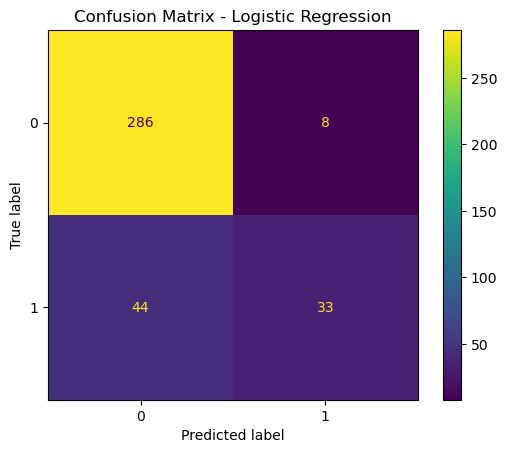

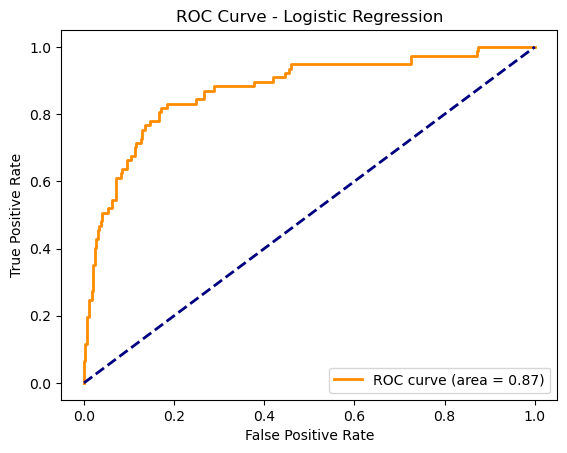

In [10]:
# -----------------------------------------------
# Health Insurance Fraud Detection 
# Logistic Regression with Full Evaluation
# -----------------------------------------------

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt

# 1. Start Spark Session
spark = SparkSession.builder.appName("HealthInsuranceFraudDetection").getOrCreate()

# 2. Load CSV data (converted from Excel)
df = spark.read.csv("Merged_4csv.csv", header=True, inferSchema=True).dropna()

# 3. Convert PotentialFraud to numeric label
label_indexer = StringIndexer(inputCol="PotentialFraud", outputCol="label")

# 4. Feature Assembly (exclude ID and label)
features = [col for col in df.columns if col not in ("Provider", "PotentialFraud")]
assembler = VectorAssembler(inputCols=features, outputCol="features_assembled")

# 5. Feature Scaling
scaler = StandardScaler(inputCol="features_assembled", outputCol="features")

# 6. Train-Test Split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# 7. Define Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# 8. Create ML Pipeline
pipeline = Pipeline(stages=[label_indexer, assembler, scaler, lr])
model = pipeline.fit(train_data)

# 9. Make Predictions
predictions = model.transform(test_data)

# 10. Evaluation Metrics
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

# Extra Metrics
predictions = predictions.withColumn("tp", when((col("label") == 1) & (col("prediction") == 1), 1).otherwise(0))
predictions = predictions.withColumn("tn", when((col("label") == 0) & (col("prediction") == 0), 1).otherwise(0))
predictions = predictions.withColumn("fp", when((col("label") == 0) & (col("prediction") == 1), 1).otherwise(0))
predictions = predictions.withColumn("fn", when((col("label") == 1) & (col("prediction") == 0), 1).otherwise(0))

agg = predictions.selectExpr(
    "sum(tp) as TP",
    "sum(tn) as TN",
    "sum(fp) as FP",
    "sum(fn) as FN"
).collect()[0]

TP, TN, FP, FN = agg['TP'], agg['TN'], agg['FP'], agg['FN']
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Export for Visuals
predictions_pd = predictions.select("label", "prediction", "probability").toPandas()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("confusion_matrix_logistic.png")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc as calc_auc

fpr, tpr, _ = roc_curve(predictions_pd["label"], predictions_pd["probability"].apply(lambda x: x[1]))
roc_auc = calc_auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.savefig("roc_curve_logistic.png")
plt.show()
